In [2]:
using MLDataUtils, CSV, DataFrames, CategoricalArrays, Random, Plots, JLD
using IterTools, Statistics, StatsBase, Flux, Evolutionary, Distributions

In [3]:
#Preprocessing the Data
hv_train = DataFrame(CSV.File("Hill_Valley_without_noise_Training.data"))
hv_test = DataFrame(CSV.File("Hill_Valley_without_noise_Testing.data"))
hv_data = vcat(hv_train, hv_test)
hv_x = hv_data[!, Not(:class)]
hv_y = hv_data[!, :class]
hv_x = Array{Float64}(hv_x)
hv_x = zscore(hv_x)
hv_data2 = DataFrame(hcat(hv_x, hv_y), :auto)
trainingData, testData = splitobs(hv_data2; at = 0.7)
trainX, trainY, testX, testY = trainingData[!, Not(:x101)], trainingData[!,:x101], testData[!, Not(:x101)], testData[!, :x101]

trainX = Matrix{Float32}(trainX)
testX  = Matrix{Float32}(testX)

364×100 Matrix{Float32}:
 -0.329232   -0.329231   -0.329231   …  -0.329211   -0.329215   -0.329218
 -0.390431   -0.390682   -0.390986      -0.389237   -0.389237   -0.389237
 -0.418064   -0.418064   -0.418064      -0.418063   -0.418063   -0.418063
 -0.395355   -0.395355   -0.395355      -0.395036   -0.3951     -0.39515
 -0.420407   -0.420407   -0.420407      -0.420407   -0.420407   -0.420407
 -0.388202   -0.388202   -0.388202   …  -0.388202   -0.388202   -0.388202
 -0.408343   -0.408343   -0.408343      -0.408343   -0.408343   -0.408343
 -0.413298   -0.413298   -0.413298      -0.413114   -0.413141   -0.413165
 -0.415485   -0.415484   -0.415484      -0.415485   -0.415485   -0.415485
 -0.415752   -0.415752   -0.415752      -0.415783   -0.415776   -0.41577
 -0.410782   -0.410782   -0.410782   …  -0.410782   -0.410782   -0.410782
 -0.411737   -0.411737   -0.411737      -0.411593   -0.411626   -0.411652
  0.940997    0.945801    0.951571       0.917101    0.917101    0.917101
  ⋮            

In [4]:
trainData = []
for i in range(start=1, stop=size(trainX, 1), step=1)
    push!(trainData, (trainX[i, :], [trainY[i]]))
end
testData = []
for i in range(start=1, stop=size(testX, 1), step=1)
    push!(testData, (testX[i, :], [testY[i]]))
end

In [5]:
#Confusion Matrix function
function getConfusionMatrix(model, data)
    VALLEY, HILL = 0, 1
    tPos, tNeg, fPos, fNeg = 0, 0, 0, 0
    for i in 1:size(data, 1)
        if model(data[i][1])[1] >= 0.5 && data[i][2][1] == HILL
            tPos += 1
        elseif model(data[i][1])[1] >= 0.5 && data[i][2][1] == VALLEY
            tNeg += 1
        elseif model(data[i][1])[1] < 0.5 && data[i][2][1] == HILL
            fPos += 1
        else
            fNeg += 1
        end
    end
    return [tPos tNeg ; fPos fNeg]
end

getConfusionMatrix (generic function with 1 method)

In [6]:
#Getting a local optimum model from Backprop
data = vcat(trainData, testData)
best = Chain(Dense(100, 200, σ), Dense(200, 1, σ))
best_conf = getConfusionMatrix(best, data)
best_accuracy = (best_conf[1, 1] + best_conf[2, 2]) / (best_conf[1, 1] + best_conf[1, 2] + best_conf[2, 1] + best_conf[2, 2])
for i in 1:10
println("Training model " * string(i))
model = Chain(Dense(100, 200, σ), Dense(200, 1, σ))
loss(x, y) = Flux.mse(model(x), y)
optimizer = ADAM()
for epoch in 1:300
    Flux.train!(loss, Flux.params(model), trainData, optimizer)
end
conf = getConfusionMatrix(model, data)
accuracy = (conf[1, 1] + conf[2, 2]) / (conf[1, 1] + conf[1, 2] + conf[2, 1] + conf[2, 2])
if accuracy > best_accuracy
        best = model
        best_accuracy = accuracy
end
end

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


In [7]:
#Individual Representation and helper functions
struct Individual{Float32}
    W1::Matrix{Float32}
    b1::Vector{Float32}
    W2::Matrix{Float32}
    b2::Vector{Float32}
    mask::String             #mask = "0000000100000010000..." -> size = 20,000
end

function str2mat(mask)
    mat = [parse(Int32, i) for i in mask]
    return reshape(mat, (200, 100))
end

function mat2str(mask)
    mask = reshape(mask, (20000,))
    s = ""
    for i in mask
        s *= string(i)
    end
    return s
end

function applyMask(I::Individual)
    return I.W1 .* str2mat(I.mask)
end

function getRandomMask()
    x = zeros(Int8, 20000)
    ones = sample(1:20000, 2000, replace = false)
    for i in ones
        x[i] = 1
    end
    return reshape(x, (200,100))
end

function getNN(I::Individual)
    model = Chain(Dense(applyMask(I), I.b1, σ), Dense(I.W2, I.b2, σ))
    return model
end

function getNNParams(I::Individual)
    return [applyMask(I), I.b1, I.W2, I.b2]
end

function getAccuracy(model)
    conf = getConfusionMatrix(model, data)
    return (conf[1, 1] + conf[2, 2]) / (conf[1, 1] + conf[1, 2] + conf[2, 1] + conf[2, 2])
end

getAccuracy (generic function with 1 method)

In [8]:
#Helper functions and Mutation, Selection, Crossover and Fitness functions
function getPositions(mask::Matrix{Int32})
    opos, zpos = [], []
    for i in 1:length(mask)
        if mask[i] == 0
            push!(zpos, i)
        else
            push!(opos, i)
        end
    end
    return opos, zpos
end

function getOnes(mask::String)
    return [i for i in 1:length(mask) if mask[i] == '1']
end

function mutate(I::Individual)
    opos, zpos = getPositions(str2mat(I.mask))
    swapone = rand(opos)
    swapzero = rand(zpos)
    mask = reshape(str2mat(I.mask), (length(I.mask),))
    mask[swapone] = 0
    mask[swapzero]= 1
    mask = mat2str(mask)
    return Individual(I.W1, I.b1, I.W2, I.b2, mask)
end

function uniform_crossover(I1::Individual, I2::Individual)
    p1 = getOnes(I1.mask)
    p2 = getOnes(I2.mask)
    childones = sample(collect(Set(shuffle!(vcat(p1, p2)))), 2000, replace=false)
    childmask = zeros(Int8, length(I1.mask))
    for i in 1:size(childones, 1)
        childmask[childones[i]] = 1
    end
    return Individual(I1.W1, I1.b1, I1.W2, I1.b2, mat2str(childmask))
end

function fitness(I::Individual)
    return getAccuracy(getNN(I))
end

function selection(population)   #Roulette Wheel Selection
    w = [fitness(population[1])]
    for k in 2:size(population, 1)
        push!(w, w[k-1]+fitness(population[k]))
    end
    chosen = [1, 1]
    for p in 1:2
        a = rand(Uniform(0, w[end]))
        while a > w[chosen[p]]
            chosen[p] += 1
        end
    end
    return population[chosen[1]], population[chosen[2]]
end

function getfitnesses(population)
    fitnesses = []
    for p in population
        push!(fitnesses, fitness(p))
    end
    return fitnesses
end

function replace(population, child::Individual)
    fitnesses = getfitnesses(population)
    if fitness(child) > minimum(fitnesses)
        deleteat!(population, argmin(fitnesses))
        push!(population, child)
        return population
    else
        return population
    end
end


replace (generic function with 1 method)

In [10]:
#GA Implementation
avg_fitness_1 = [0.0 for i in 1:1000]
p = Flux.params(best)
best_GA = 0
for exp in 1:10
println("Experiment: "*string(exp))
population1 = [Individual(p[1], p[2], p[3], p[4], mat2str(getRandomMask())) for i in 1:5]
fs = getfitnesses(population1)
GA_fitnesses = [maximum(fs)]
generations = [1]
for generation in 2:1000
    if generation % 100 == 0
        println("Generation: "*string(generation))
    end
    flag = false
    parent1, parent2 = selection(population1)
    if rand() <= 0.9
        child1 = uniform_crossover(parent1, parent2)
        if rand() >= 0.9
            child1 = mutate(child1)
        end
        flag = true
    end
    if flag
        population1 = replace(population1, child1)
    end
    fitnesses = getfitnesses(population1)
    push!(GA_fitnesses, maximum(fitnesses))
    push!(generations, generation)
    best_GA = population1[argmax(fitnesses)]
end
for i in 1:1000
    if avg_fitness_1[i] == 0.0
        avg_fitness_1[i] = GA_fitnesses[i]
    else
        avg_fitness_1[i] = (avg_fitness_1[i] + GA_fitnesses[i]) / 2
    end
end
end

Experiment: 1
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Experiment: 2
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Experiment: 3
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Experiment: 4
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Experiment: 5
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Experiment: 6
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700

In [53]:
#Creating simple baseline model for comparison
baseline_mask = zeros(Int8, (100, 200))
baseline_weights = reshape(p[1], (20000,))
b = sortperm(baseline_weights)
maxk = collect(zip(b, baseline_weights[b]))[18001:end]
for elem in maxk
    baseline_mask[elem[1]] = 1
end
baseline_individual =Individual(p[1], p[2], p[3], p[4], mat2str(baseline_mask))
baseline_fitness = fitness(baseline_individual)

0.5132013201320133

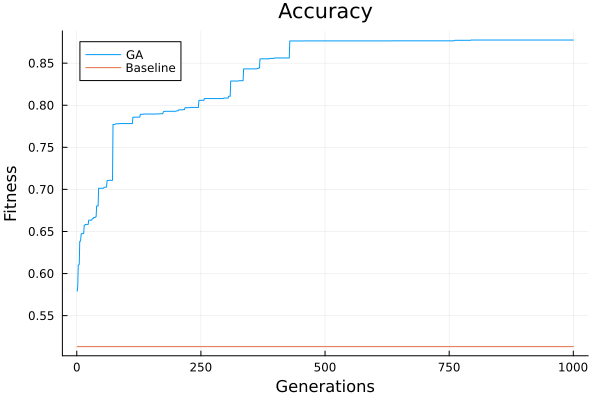

In [55]:
# Comparison of GA and Baseline model
plot(range(start=1, stop=1000, step=1), [avg_fitness_1 [baseline_fitness for i in 1:1000]], title="Accuracy", label=["GA" "Baseline"])
xlabel!("Generations")
ylabel!("Fitness")

In [56]:
fitness(best_GA)

0.9117161716171617

In [57]:
#Training Confusion Matrix for best model found in GA
train_conf = getConfusionMatrix(getNN(best_GA), trainData)

2×2 Matrix{Int64}:
 375   38
  35  400

In [90]:
#Testing Confusion Matrix for best model found in GA
test_conf = getConfusionMatrix(getNN(best_GA), testData)

2×2 Matrix{Int64}:
 182   14
  20  148

In [91]:
#Training Confusion Matrix for baseline Individual
train_conf = getConfusionMatrix(getNN(baseline_individual), trainData)

2×2 Matrix{Int64}:
 337  349
  73   89

In [92]:
#Testing Confusion Matrix for baseline Individual
test_conf = getConfusionMatrix(getNN(baseline_individual), testData)

2×2 Matrix{Int64}:
 165  131
  37   31

In [17]:
save("best_GA.jld", "5", best_GA)

In [19]:
#Further Optimization attempt
population2 = [Individual(p[1], p[2], p[3], p[4], mat2str(getRandomMask())) for i in 1:100]
fs_new = getfitnesses(population2)
GA_fitnesses_new = [maximum(fs_new)]
generations = [1]
best_GA_new = population2[argmax(fs_new)]
for generation in 2:500
    println("Generation: "*string(generation))
    flag = false
    parent1 = best_GA
    parent2, parent3 = selection(population2)
    if rand() <= 0.9
        child = uniform_crossover(parent1, rand([parent2, parent3]))
        if rand() >= 0.9
            child = mutate(child)
        end
        flag = true
    end
    if flag
        population2 = replace(population2, child)
    end
    fitnesses = getfitnesses(population2)
    push!(GA_fitnesses_new, maximum(fitnesses))
    push!(generations, generation)
    best_GA_new = population2[argmax(fitnesses)]
end

Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Generation: 68
Gen

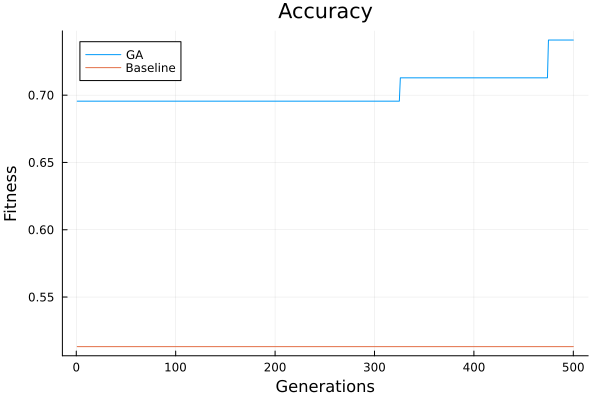

In [61]:
#Comparing with baseline
plot(generations, [GA_fitnesses_new [baseline_fitness for i in 1:500]], title="Accuracy", label=["GA" "Baseline"])
xlabel!("Generations")
ylabel!("Fitness")

In [62]:
fitness(best_GA_new)

0.740924092409241

In [64]:
# Defining Generation function
function GA(population)
    flag = false
    parent1, parent2 = selection(population)
    if rand() <= 0.9
        child = uniform_crossover(parent1, parent2)
        if rand() >= 0.9
            child = mutate(child)
        end
        flag = true
    end
    if flag
        population = replace(population, child)
    end
    return population
end

GA (generic function with 1 method)

In [97]:
#Creating 3 separate populations
population3 = [Individual(p[1], p[2], p[3], p[4], mat2str(getRandomMask())) for i in 1:24]
push!(population3, best_GA)
population4 = [Individual(p[1], p[2], p[3], p[4], mat2str(getRandomMask())) for i in 1:24]
push!(population4, best_GA_new)
population5 = [Individual(p[1], p[2], p[3], p[4], mat2str(getRandomMask())) for i in 1:25]
fs_3 = getfitnesses(population3)
GA_fitnesses_3 = [maximum(fs_3)]
best_GA_3 = population3[argmax(fs_3)]
fs_4 = getfitnesses(population4)
GA_fitnesses_4 = [maximum(fs_4)]
best_GA_4 = population3[argmax(fs_4)]
fs_5 = getfitnesses(population5)
GA_fitnesses_5 = [maximum(fs_5)]
best_GA_5 = population3[argmax(fs_5)]

Individual{Float32}(Float32[-1.5376443 -1.4611418 … -1.7510945 -1.8241984; 1.8574678 1.8366371 … 1.6222512 1.8783398; … ; -1.2267957 -1.0628706 … -1.4328306 -1.2957104; 1.3316135 1.3061591 … 1.2107664 1.4556291], Float32[-0.49253246, -0.44974104, -10.7711735, -1.376677, -1.104824, -1.8528644, -0.014099269, 0.3420185, -1.7485881, -13.127456  …  -1.2015672, -0.4563777, 0.15965493, -0.91972715, 0.2574225, 0.14528222, 0.007985529, -13.117754, -1.4188379, -1.4857429], Float32[0.6324752 -0.47188014 … 0.09967088 -0.111171514], Float32[0.01103911], "01001010000000000000000000000000110100000000100000000000001010000000000000000000010000000000011000010000000000000000100000010100001000010100000000100000000001001010000000000000000000000000000000000000000000000010010000000100100100000000000000000000000000100000000000000010000010000000000000100100001000000000000000000001000000000100000000001001001000000000000000000010010000000000000000000000001011010000000010000000000000000010000000000000000000001000

In [98]:
#Further Optimization attempt
for generation in 2:505
    if generation % 50 == 0
        println("Generation: "*string(generation))
    end
    population3, population4, population5 = GA(population3), GA(population4), GA(population5)
    
    fitnesses3 = getfitnesses(population3)
    push!(GA_fitnesses_3, maximum(fitnesses3))
    best_GA_3 = population3[argmax(fitnesses3)]
    
    fitnesses4 = getfitnesses(population4)
    push!(GA_fitnesses_4, maximum(fitnesses4))
    best_GA_4 = population4[argmax(fitnesses4)]
    
    fitnesses5 = getfitnesses(population5)
    push!(GA_fitnesses_5, maximum(fitnesses5))
    best_GA_5 = population5[argmax(fitnesses5)]
    
    if generation % 100 == 0
        r1 = rand()
        if r1 < 0.33
            r2 = rand()
            if r2 < 0.5
                population4 = replace(population4, best_GA_3)
            else
                population5 = replace(population5, best_GA_3)
            end
        elseif r1 < 0.66
            r2 = rand()
            if r2 < 0.5
                population4 = replace(population4, best_GA_4)
            else
                population5 = replace(population5, best_GA_4)
            end
        else
            r2 = rand()
            if r2 < 0.5
                population4 = replace(population4, best_GA_5)
            else
                population5 = replace(population5, best_GA_5)
            end
        end
    end
end

Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450
Generation: 500


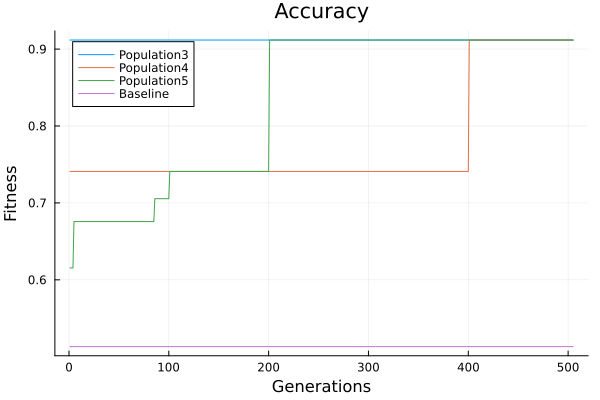

In [100]:
#Comparing Results
plot(1:505, [GA_fitnesses_3  GA_fitnesses_4 GA_fitnesses_5 [baseline_fitness for i in 1:505]], title="Accuracy", label=["Population3" "Population4" "Population5" "Baseline"])
xlabel!("Generations")
ylabel!("Fitness")

In [104]:
mean(GA_fitnesses_3)

0.9117161716171612

In [105]:
mean(GA_fitnesses_4)

0.7764353167990073

In [106]:
mean(GA_fitnesses_5)

0.8315737019246475